<a href="https://colab.research.google.com/github/DavidVollendroff/All-NBA/blob/master/notebooks/Build%20Project%202%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
pd.options.display.max_rows = 500

# Initial Data Gathering

The first steps are to aggregate the personal statisitics and team statistics for each player.

The data is from seasons starting in 1989 and later because of the change to All-NBA voting that occurred in that year.

In [0]:
# individual stats and filtering to Centers only
seasons = [yr for yr in range(1990, 2021)]
data = {}
dropped_columns = ['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G']
traditional_stats_url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html#per_game_stats::none'
advanced_stats_url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'
for season in seasons:
  traditional_stats = pd.read_html(traditional_stats_url.format(season))
  advanced_stats = pd.read_html(advanced_stats_url.format(season))
  traditional_centers = traditional_stats[0][traditional_stats[0]['Pos']=='C'].dropna(axis=1,thresh=10)
  traditional_centers = traditional_centers.drop(columns=dropped_columns)
  traditional_centers = traditional_centers.rename(columns={'MP':'MP/G'})
  advanced_centers = advanced_stats[0][advanced_stats[0]['Pos']=='C'].dropna(axis=1,thresh=10)
  
  data['{}-{}'.format(season -1, str(season)[-2:])] = pd.merge(traditional_centers, advanced_centers, how='outer', on=traditional_centers.index)

In [0]:
# trims the * from the end of players who've been inducted to the Hall of Fame
def hof_remover(some_string):
  if some_string.endswith('*'):
    return some_string[:-1]
  else:
    return some_string

for key in data.keys():
  data[key]['Player'] = data[key]['Player'].apply(hof_remover)

In [5]:
# gathering team statistics
wins_dict = {}
standings_url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html"
for season in seasons:
  standings = pd.read_html(standings_url.format(season))
  standings = pd.concat(standings[:2])
  # wins = standings[0]['W'].dropna(axis=1)
  wins_dict['{}-{}'.format(season -1, str(season)[-2:])] = standings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [0]:
# team data wrangling
for key in wins_dict.keys():
  wins_dict[key] = wins_dict[key][~wins_dict[key]['GB'].str.contains('Division')]
  wins_dict[key]['Team'] = pd.concat([wins_dict[key]['Eastern Conference'], wins_dict[key]['Western Conference']], axis=0).dropna()
  wins_dict[key] = wins_dict[key].drop(['Eastern Conference', 'Western Conference'], axis=1)

In [0]:
# for parsing strings which hold playoff seeding information
team_abr = ['OKC', 'MIA', 'MIN', 'SAS', 'BRK', 'IND', 'NOP', 'CHI',
       'BOS', 'GSW', 'ORL', 'HOU', 'LAL', 'UTA', 'SAC', 'PHO', 'POR',
       'MEM', 'ATL', 'DET', 'PHI', 'CLE', 'WAS', 'LAC', 'MIL', 'NYK',
       'CHO', 'DEN', 'DAL', 'TOR', 'CHA', 'NOH', 'NJN', 'SEA', 'NOK',
       'CHH', 'VAN', 'WSB']
team_cities = ['Oklahoma City', 'Miami', 'Minnesota', 'San Antonio', 'Brooklyn', 'Indiana',
            'New Orleans', 'Chicago', 'Boston', 'Golden State', 'Orlando', 'Houston',
            'Los Angeles Lakers', 'Utah', 'Sacramento', 'Phoenix', 'Portland', 'Memphis',
            'Atlanta', 'Detroit', 'Philadelphia', 'Cleveland', 'Washington', 'Los Angeles Clippers',
            'Milwaukee', 'New York', 'Charlotte', 'Denver', 'Dallas', 'Toronto', 'Charlotte',
            'New Orleans', 'New Jersey', 'Seattle', 'New Orleans', 'Charlotte', 'Vancouver',
            'Washington']

abr_city = dict(zip(team_abr, team_cities))


# Next I compile information about winners of the All-NBA votes.

In [0]:
# All-NBA Awards List
url = 'https://www.basketball-reference.com/awards/all_league.html'
all_nba = pd.read_html(url) # pulls from the web
all_nba = all_nba[0] # removes from the list
all_nba = all_nba.dropna() # drops spacer rows
all_nba = all_nba[['Season', 'Unnamed: 3']] # selects only the Centers
all_nba = all_nba.set_index('Season') # removes useless index

In [0]:
# Trimming the ' C' from player names
def trim(some_string):
  return some_string[:-2]
all_nba = all_nba['Unnamed: 3'].apply(trim)

In [0]:
modern_all_nba = pd.DataFrame(all_nba[(all_nba.index >'1988-89')])

# Merging Dataframes to add All-NBA Award columns

In [0]:
# creating labels corresponding to 3 points for a first place finish, 2 for 2nd,
# and 1 for making the 3rd team.
votes = np.repeat([[5,3,1]], 30, axis=0).flatten()
modern_all_nba['votes'] = votes
modern_all_nba.rename(columns={'Unnamed: 3': 'Player'}, inplace=True)

In [0]:
#importing re allows me to parse the strings from standings data
import re

# Remove traded players

No center traded during the season has ever made the All-NBA team. I'll throw this data out because it causes so many issues down the line.

In [0]:
# where a player is listed more than once it indicates they have been traded
# during the season. this causes issues later and leaving them out should not 
# cause much information loss.
for key in data.keys():
  if data[key]['Player'].value_counts().max() > 1:
    condition = data[key]['Player'].value_counts() > 1
    x = condition.value_counts()[True]
    traded_list = condition.index[:x].to_list()
    data[key] = data[key][~data[key]['Player'].isin(traded_list)]

# Affixing award information as well as team seed statistic.

In [0]:
# merges player stats, awards information and then affixes team win-total info
merged_data = {}
for key in data.keys():
  merged_data[key] = pd.merge(data[key], modern_all_nba[modern_all_nba.index==key], how='left', on='Player')
  merged_data[key].fillna(0, inplace=True) # label dropped for latest season
  merged_data[key]['Season'] = np.repeat(key, len(merged_data[key]))
  merged_data[key]['team_city'] = merged_data[key]['Tm'].map(abr_city)
  
  # Parses team playoff seed value from standings data and adds to new column
  df = merged_data[key] # df relating to given season
  df['Seed'] = np.zeros(len(df)) # adds empty column to populate
  stdgs = wins_dict[key]
  df.dropna(subset=['team_city'], inplace=True)
  seed_list = []
  for i in range(len(df)):
    seed = stdgs[stdgs['Team'].str.startswith(df.iloc[i]['team_city'])].iloc[0]
    seed = seed['Team']
    seed = re.findall(r'\d+', seed)
    if df.iloc[i]['team_city'].startswith('Philadelphia'): # 76ers :(
      seed = int(seed[1])
    else:
      seed = int(seed[0])
    seed_list.append(seed)
  df['Seed'] = seed_list
  merged_data[key] = df


# Readying our data to feed a model

In [0]:
latest_seasons = ['2017-18', '2018-19', '2019-20']
df_list = []
for key in merged_data.keys():
  if key not in latest_seasons:
    df_list.append(merged_data[key])
train = pd.concat(df_list, axis=0) # seasons not specified become training data
validate = pd.concat((merged_data[latest_seasons[0]],merged_data[latest_seasons[1]]), axis=0) # last season used for validation
test = merged_data[latest_seasons[2]] # current season to be used for prediction

In [0]:
target = 'votes' # what we'll predict with regression

features = train.columns.tolist() # all possible features

removed_features = ['Player', # those we'll remove
                    'Pos', # All players already filtered by position
                    'Rk', # nonsense feature
                    'votes', # the target
                    'Tm', # May cause leakage
                    'team_city', # May cause leakage
                    'Season', # May cause leakage
                    'key_0' # nonsense feature
                    ]

for item in removed_features:
  if item in features:
    features.remove(item)

In [0]:
# features matrix and target vector 
X_train = train[features].astype(float)
y_train = train[target].astype(float)
X_val = validate[features].astype(float)
y_val = validate[target].astype(float)
X_test = test[features].astype(float)

# Creating the pipeline

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

In [0]:
# create model which ended up requiring no preprocessing pipeline
pipe = RandomForestRegressor(max_depth=None, n_estimators=1200) #
pipe.fit(X_train, y_train);

# Scoring: Train, Eval and Test

In [20]:
pipe.score(X_train, y_train)

0.9421290935095644

In [21]:
eval_score = pipe.score(X_val[validate['Season']=='2017-18'], y_val[validate['Season']=='2017-18'])
print("Eval score: {}".format(eval_score))

Eval score: -0.3525821362717101


In [22]:
test_score = pipe.score(X_val[validate['Season']=='2018-19'], y_val[validate['Season']=='2018-19'])
print("Test score: {}".format(test_score))

Test score: 0.41250967704325503


At the end of the day these metrics aren't especially meaningful when it comes to my end goal. I could score different models to test hyperparameter optimization and linear versus tree-based outcomes. But ultimately these numbers are not very important because the goal is to rank players by relative worthiness. To guide my decisions moving forward I'll be looking directly at the ranking outcomes and comparing what I see to the voting records available for these more recent seasons.

In [0]:
new_validate = validate.copy()
new_validate['votes'] = pipe.predict(X_val)

In [24]:
twenty_eighteen = new_validate[new_validate['Season'] == '2017-18'].sort_values(by='votes', ascending=False)[:10]
twenty_eighteen

,key_0,GS,MP/G,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,votes,Season,team_city,Seed
19,139,48,36.2,8.5,18.0,.470,2.2,6.1,.354,6.3,11.9,.530,.530,6.1,8.2,.746,2.2,10.7,12.9,5.4,1.6,1.6,5.0,3.8,25.2,112,DeMarcus Cousins,C,27,NOP,48,1737,22.6,.583,.340,.456,6.8,30.9,19.2,23.0,2.2,3.5,18.9,31.9,1.5,3.2,4.7,.130,1.9,3.6,5.5,3.3,1.983333,2017-18,New Orleans,6
42,337,73,32.6,6.7,13.5,.499,1.5,3.7,.396,5.2,9.7,.538,.554,3.5,4.2,.850,2.6,8.1,10.7,6.1,1.2,0.8,2.8,2.8,18.5,263,Nikola Jokić,C,22,DEN,75,2443,24.4,.603,.277,.310,9.0,27.9,18.5,29.6,1.8,2.1,15.5,24.2,7.8,2.9,10.7,.211,4.8,2.3,7.1,5.6,1.550833,2017-18,Denver,9
84,615,82,35.6,7.8,14.3,.545,1.5,3.5,.421,6.3,10.8,.585,.596,4.2,4.9,.858,2.9,9.4,12.3,2.4,0.8,1.4,1.9,3.5,21.3,483,Karl-Anthony Towns,C,22,MIN,82,2918,24.9,.646,.243,.343,9.3,30.9,20.0,10.8,1.1,3.5,10.5,22.9,10.6,3.4,14.0,.230,4.4,1.1,5.5,5.5,1.331667,2017-18,Minnesota,8
24,174,78,33.7,6.0,11.3,.529,0.0,0.1,.000,6.0,11.2,.536,.529,3.1,5.1,.605,5.1,10.9,16.0,3.0,1.5,1.6,2.6,3.2,15.0,140,Andre Drummond,C,24,DET,78,2625,22.9,.555,.012,.448,16.4,36.4,26.2,14.3,2.2,4.3,15.9,21.2,4.6,5.7,10.3,.189,0.2,5.3,5.5,5.0,1.193333,2017-18,Detroit,9
25,184,63,30.3,8.1,16.8,.483,1.0,3.4,.308,7.0,13.4,.527,.514,5.7,7.4,.769,2.3,8.7,11.0,3.2,0.6,1.8,3.7,3.3,22.9,147,Joel Embiid,C,23,PHI,63,1912,22.9,.573,.203,.442,8.4,29.7,19.4,18.0,1.0,4.8,15.6,33.4,2.3,3.8,6.2,.155,0.1,2.5,2.6,2.2,0.941667,2017-18,Philadelphia,3
3,6,75,33.5,9.2,18.0,.510,0.4,1.2,.293,8.8,16.7,.526,.520,4.5,5.3,.837,3.3,5.2,8.5,2.0,0.6,1.2,1.5,2.1,23.1,7,LaMarcus Aldridge,C,32,SAS,75,2509,25.0,.570,.068,.296,10.8,17.3,14.0,11.3,0.9,3.0,6.8,29.1,7.4,3.5,10.9,.209,3.0,0.3,3.3,3.3,0.861667,2017-18,San Antonio,7
44,346,77,31.5,4.8,7.5,.645,0.0,0.0,0,4.8,7.5,.645,.645,2.4,4.1,.580,4.3,10.9,15.2,1.5,0.5,0.9,1.8,2.6,12.0,268,DeAndre Jordan,C,29,LAC,77,2424,20.2,.648,.000,.540,15.1,37.6,26.5,7.1,0.8,2.4,16.1,15.2,6.0,3.4,9.4,.186,0.5,1.6,2.1,2.5,0.455833,2017-18,Los Angeles Clippers,10
14,107,74,27.5,6.0,9.1,.652,0.0,0.0,.000,6.0,9.1,.653,.652,1.9,3.5,.560,3.3,7.6,10.8,0.9,0.8,1.9,1.4,2.5,13.9,85,Clint Capela,C,23,HOU,74,2034,24.5,.650,.001,.380,13.5,30.8,22.2,5.7,1.4,5.7,11.5,19.4,6.2,4.1,10.2,.242,0.1,2.9,3.0,2.6,0.417500,2017-18,Houston,1
38,291,81,30.4,6.2,11.2,.555,0.0,0.1,.143,6.2,11.2,.559,.556,4.1,7.2,.574,3.1,9.3,12.5,1.3,0.6,1.6,2.6,3.1,16.6,229,Dwight Howard,C,32,CHO,81,2463,20.5,.577,.008,.639,11.0,33.8,22.2,7.1,1.0,4.4,15.1,24.2,2.9,3.9,6.8,.132,-2.0,1.7,-0.3,1.1,0.197500,2017-18,Charlotte,10
90,655,54,25.3,5.8,10.7,.540,0.0,0.0,1.000,5.7,10.7,.538,.542,2.4,3.4,.703,3.2,8.2,11.4,1.0,0.7,1.7,1.7,2.4,14.0,513,Hassan Whiteside,C,28,MIA,54,1364,24.1,.573,.003,.315,14.3,36.6,25.4,6.9,1.4,5.9,12.3,24.7,2.3,3.0,5.3,.187,-2.1,2.3,0.2,0.8,0.115833,2017-18,Miami,6


In [25]:
twenty_nineteen = new_validate[new_validate['Season'] == '2018-19'].sort_values(by='votes', ascending=False)[:10]
twenty_nineteen

,key_0,GS,MP/G,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,votes,Season,team_city,Seed
27,207,64,33.7,9.1,18.7,.484,1.2,4.1,.300,7.8,14.6,.535,.517,8.2,10.1,.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,155,Joel Embiid,C,24,PHI,64,2154,26.1,.593,.219,.541,8.1,34.0,21.4,18.4,1.0,4.4,13.2,33.3,4.9,3.8,8.7,.194,2.0,2.1,4.1,3.3,2.720000,2018-19,Philadelphia,3
19,167,56,33.0,9.5,18.3,.517,0.9,2.6,.331,8.6,15.7,.547,.540,6.1,7.7,.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,126,Anthony Davis,C,25,NOP,56,1850,30.3,.597,.141,.422,9.9,27.5,18.8,19.0,2.2,6.0,8.4,29.5,6.4,3.1,9.5,.247,4.7,3.9,8.5,4.9,2.256667,2018-19,New Orleans,13
31,253,80,31.8,5.9,8.8,.669,0.0,0.0,0,5.9,8.8,.669,.669,4.1,6.4,.636,3.8,9.0,12.9,2.0,0.8,2.3,1.6,2.9,15.9,187,Rudy Gobert,C,26,UTA,81,2577,24.6,.682,.000,.733,13.2,30.2,21.9,9.6,1.2,5.8,12.1,17.8,8.7,5.7,14.4,.268,2.0,5.1,7.0,5.9,2.159167,2018-19,Utah,5
44,366,80,31.3,7.7,15.1,.511,1.0,3.4,.307,6.7,11.7,.569,.545,3.6,4.4,.821,2.9,8.0,10.8,7.3,1.4,0.7,3.1,2.9,20.1,269,Nikola Jokić,C,23,DEN,80,2504,26.3,.589,.224,.292,9.8,27.6,18.7,37.0,2.1,1.9,15.4,27.4,7.5,4.3,11.8,.226,5.7,3.8,9.5,7.3,2.133333,2018-19,Denver,2
73,670,77,33.1,8.8,17.1,.518,1.8,4.6,.400,7.0,12.5,.562,.572,4.9,5.8,.836,3.4,9.0,12.4,3.4,0.9,1.6,3.1,3.8,24.4,480,Karl-Anthony Towns,C,23,MIN,77,2545,26.3,.622,.270,.342,10.9,29.3,20.0,17.2,1.3,4.2,13.7,28.9,7.2,3.2,10.4,.197,4.8,2.0,6.8,5.7,1.643333,2018-19,Minnesota,11
76,685,80,31.4,8.8,16.9,.518,1.1,2.9,.364,7.7,14.0,.549,.549,2.2,2.8,.789,2.8,9.2,12.0,3.8,1.0,1.1,2.0,2.0,20.8,492,Nikola Vučević,C,28,ORL,80,2510,25.5,.573,.171,.168,9.4,31.9,20.5,21.9,1.6,3.0,9.9,28.0,5.4,4.7,10.1,.193,3.0,3.4,6.4,5.3,1.359167,2018-19,Orlando,7
26,195,79,33.5,7.1,13.3,.533,0.1,0.5,.132,7.0,12.8,.548,.536,3.1,5.2,.590,5.4,10.2,15.6,1.4,1.7,1.7,2.2,3.4,17.3,147,Andre Drummond,C,25,DET,79,2647,23.4,.555,.036,.392,16.8,34.7,25.4,7.2,2.5,4.4,12.4,22.9,4.1,5.9,10.0,.181,-0.7,3.6,2.9,3.3,0.658333,2018-19,Detroit,8
14,116,67,33.6,7.1,10.9,.648,0.0,0.0,0,7.1,10.9,.648,.648,2.5,3.9,.636,4.4,8.2,12.7,1.4,0.7,1.5,1.4,2.5,16.6,89,Clint Capela,C,24,HOU,67,2249,23.8,.658,.000,.357,14.4,27.6,20.8,7.1,1.0,3.9,10.0,18.2,7.8,3.0,10.8,.230,1.3,1.6,2.9,2.8,0.439167,2018-19,Houston,4
2,7,81,33.2,8.4,16.3,.519,0.1,0.5,.238,8.3,15.8,.528,.522,4.3,5.1,.847,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,8,LaMarcus Aldridge,C,33,SAS,81,2687,22.9,.576,.032,.312,10.3,19.8,15.1,11.6,0.8,3.4,8.8,26.9,6.4,2.9,9.3,.167,1.2,0.5,1.6,2.5,0.239167,2018-19,San Antonio,7
33,279,5,26.3,6.7,10.8,.615,0.0,0.2,.176,6.6,10.6,.623,.617,3.2,5.0,.643,2.2,4.3,6.5,2.0,0.9,1.3,1.6,3.1,16.6,208,Montrezl Harrell,C,25,LAC,82,2158,23.4,.636,.019,.466,9.3,16.7,13.1,12.5,1.6,4.0,11.0,23.5,6.1,2.6,8.7,.193,2.6,1.6,4.2,3.4,0.125833,2018-19,Los Angeles Clippers,8


#Monkey Patching An Old Library

In [26]:
!pip install forestci

In [27]:
#@title
import copy
import forestci as fci

def calc_inbag(n_samples, forest):
    """
    Derive samples used to create trees in scikit-learn RandomForest objects.
    Recovers the samples in each tree from the random state of that tree using
    :func:`forest._generate_sample_indices`.
    Parameters
    ----------
    n_samples : int
        The number of samples used to fit the scikit-learn RandomForest object.
    forest : RandomForest
        Regressor or Classifier object that is already fit by scikit-learn.
    Returns
    -------
    Array that records how many times a data point was placed in a tree.
    Columns are individual trees. Rows are the number of times a sample was
    used in a tree.
    """
    if not forest.bootstrap:
        e_s = "Cannot calculate the inbag from a forest that has "
        e_s = " bootstrap=False"
        raise ValueError(e_s)

    n_trees = forest.n_estimators
    inbag = np.zeros((n_samples, n_trees))
    sample_idx = []
    for t_idx in range(n_trees):
        sample_idx.append(
            _generate_sample_indices(forest.estimators_[t_idx].random_state,
                                     n_samples, n_samples)) # modified to work with newer sklearn
        inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)
    return inbag

Failed to import duecredit due to No module named 'duecredit'
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
#@title
def _core_computation(X_train, X_test, inbag, pred_centered, n_trees,
                      memory_constrained=False, memory_limit=None,
                      test_mode=False):
    """
    Helper function, that performs the core computation
    Parameters
    ----------
    X_train : ndarray
        An array with shape (n_train_sample, n_features).
    X_test : ndarray
        An array with shape (n_test_sample, n_features).
    inbag : ndarray
        The inbag matrix that fit the data. If set to `None` (default) it
        will be inferred from the forest. However, this only works for trees
        for which bootstrapping was set to `True`. That is, if sampling was
        done with replacement. Otherwise, users need to provide their own
        inbag matrix.
    pred_centered : ndarray
        Centered predictions that are an intermediate result in the
        computation.
    memory_constrained: boolean (optional)
        Whether or not there is a restriction on memory. If False, it is
        assumed that a ndarry of shape (n_train_sample,n_test_sample) fits
        in main memory. Setting to True can actually provide a speed up if
        memory_limit is tuned to the optimal range.
    memory_limit: int (optional)
        An upper bound for how much memory the itermediate matrices will take
        up in Megabytes. This must be provided if memory_constrained=True.
    """
    if not memory_constrained:
        return np.sum((np.dot(inbag - 1, pred_centered.T) / n_trees) ** 2, 0)

    if not memory_limit:
        raise ValueError('If memory_constrained=True, must provide',
                         'memory_limit.')

    # Assumes double precision float
    chunk_size = int((memory_limit * 1e6) / (8.0 * X_train.shape[0]))

    if chunk_size == 0:
        min_limit = 8.0 * X_train.shape[0] / 1e6
        raise ValueError('memory_limit provided is too small.' +
                         'For these dimensions, memory_limit must ' +
                         'be greater than or equal to %.3e' % min_limit)

    chunk_edges = np.arange(0, X_test.shape[0] + chunk_size, chunk_size)
    inds = range(X_test.shape[0])
    chunks = [inds[chunk_edges[i]:chunk_edges[i+1]]
              for i in range(len(chunk_edges)-1)]
    if test_mode:
        print('Number of chunks: %d' % (len(chunks),))
    V_IJ = np.concatenate([
                np.sum((np.dot(inbag-1, pred_centered[chunk].T)/n_trees)**2, 0)
                for chunk in chunks])
    return V_IJ


def _bias_correction(V_IJ, inbag, pred_centered, n_trees):
    """
    Helper functions that implements bias correction
    Parameters
    ----------
    V_IJ : ndarray
        Intermediate result in the computation.
    inbag : ndarray
        The inbag matrix that fit the data. If set to `None` (default) it
        will be inferred from the forest. However, this only works for trees
        for which bootstrapping was set to `True`. That is, if sampling was
        done with replacement. Otherwise, users need to provide their own
        inbag matrix.
    pred_centered : ndarray
        Centered predictions that are an intermediate result in the
        computation.
    n_trees : int
        The number of trees in the forest object.
    """
    n_train_samples = inbag.shape[0]
    n_var = np.mean(np.square(inbag[0:n_trees]).mean(axis=1).T.view() -
                    np.square(inbag[0:n_trees].mean(axis=1)).T.view())
    boot_var = np.square(pred_centered).sum(axis=1) / n_trees
    bias_correction = n_train_samples * n_var * boot_var / n_trees
    V_IJ_unbiased = V_IJ - bias_correction
    return V_IJ_unbiased

In [0]:
#@title
def random_forest_error(forest, X_train, X_test, inbag=None,
                        calibrate=True, memory_constrained=False,
                        memory_limit=None):
    """
    Calculate error bars from scikit-learn RandomForest estimators.
    RandomForest is a regressor or classifier object
    this variance can be used to plot error bars for RandomForest objects
    Parameters
    ----------
    forest : RandomForest
        Regressor or Classifier object.
    X_train : ndarray
        An array with shape (n_train_sample, n_features). The design matrix for
        training data.
    X_test : ndarray
        An array with shape (n_test_sample, n_features). The design matrix
        for testing data
    inbag : ndarray, optional
        The inbag matrix that fit the data. If set to `None` (default) it
        will be inferred from the forest. However, this only works for trees
        for which bootstrapping was set to `True`. That is, if sampling was
        done with replacement. Otherwise, users need to provide their own
        inbag matrix.
    calibrate: boolean, optional
        Whether to apply calibration to mitigate Monte Carlo noise.
        Some variance estimates may be negative due to Monte Carlo effects if
        the number of trees in the forest is too small. To use calibration,
        Default: True
    memory_constrained: boolean, optional
        Whether or not there is a restriction on memory. If False, it is
        assumed that a ndarry of shape (n_train_sample,n_test_sample) fits
        in main memory. Setting to True can actually provide a speed up if
        memory_limit is tuned to the optimal range.
    memory_limit: int, optional.
        An upper bound for how much memory the itermediate matrices will take
        up in Megabytes. This must be provided if memory_constrained=True.
    Returns
    -------
    An array with the unbiased sampling variance (V_IJ_unbiased)
    for a RandomForest object.
    See Also
    ----------
    :func:`calc_inbag`
    Notes
    -----
    The calculation of error is based on the infinitesimal jackknife variance,
    as described in [Wager2014]_ and is a Python implementation of the R code
    provided at: https://github.com/swager/randomForestCI
    .. [Wager2014] S. Wager, T. Hastie, B. Efron. "Confidence Intervals for
       Random Forests: The Jackknife and the Infinitesimal Jackknife", Journal
       of Machine Learning Research vol. 15, pp. 1625-1651, 2014.
    """
    if inbag is None:
        inbag = calc_inbag(X_train.shape[0], forest)

    pred = np.array([tree.predict(X_test) for tree in forest]).T
    pred_mean = np.mean(pred, 0)
    pred_centered = pred - pred_mean
    n_trees = forest.n_estimators
    V_IJ = _core_computation(X_train, X_test, inbag, pred_centered, n_trees,
                             memory_constrained, memory_limit)
    V_IJ_unbiased = _bias_correction(V_IJ, inbag, pred_centered, n_trees)

    # Correct for cases where resampling is done without replacement:
    if np.max(inbag) == 1:
        variance_inflation = 1 / (1 - np.mean(inbag)) ** 2
        V_IJ_unbiased *= variance_inflation

    if not calibrate:
        return V_IJ_unbiased

    if V_IJ_unbiased.shape[0] <= 20:
        print("No calibration with n_samples <= 20")
        return V_IJ_unbiased
    if calibrate:

        calibration_ratio = 2
        n_sample = np.ceil(n_trees / calibration_ratio)
        new_forest = copy.deepcopy(forest)
        new_forest.estimators_ =\
            np.random.permutation(new_forest.estimators_)[:int(n_sample)]
        new_forest.n_estimators = int(n_sample)

        results_ss = random_forest_error(new_forest, X_train, X_test,
                                         calibrate=False,
                                         memory_constrained=memory_constrained,
                                         memory_limit=memory_limit)
        # Use this second set of variance estimates
        # to estimate scale of Monte Carlo noise
        sigma2_ss = np.mean((results_ss - V_IJ_unbiased)**2)
        delta = n_sample / n_trees
        sigma2 = (delta**2 + (1 - delta)**2) / (2 * (1 - delta)**2) * sigma2_ss

        # Use Monte Carlo noise scale estimate for empirical Bayes calibration
        V_IJ_calibrated = fci.calibration.calibrateEB(V_IJ_unbiased, sigma2)

        return V_IJ_calibrated

No calibration with n_samples <= 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


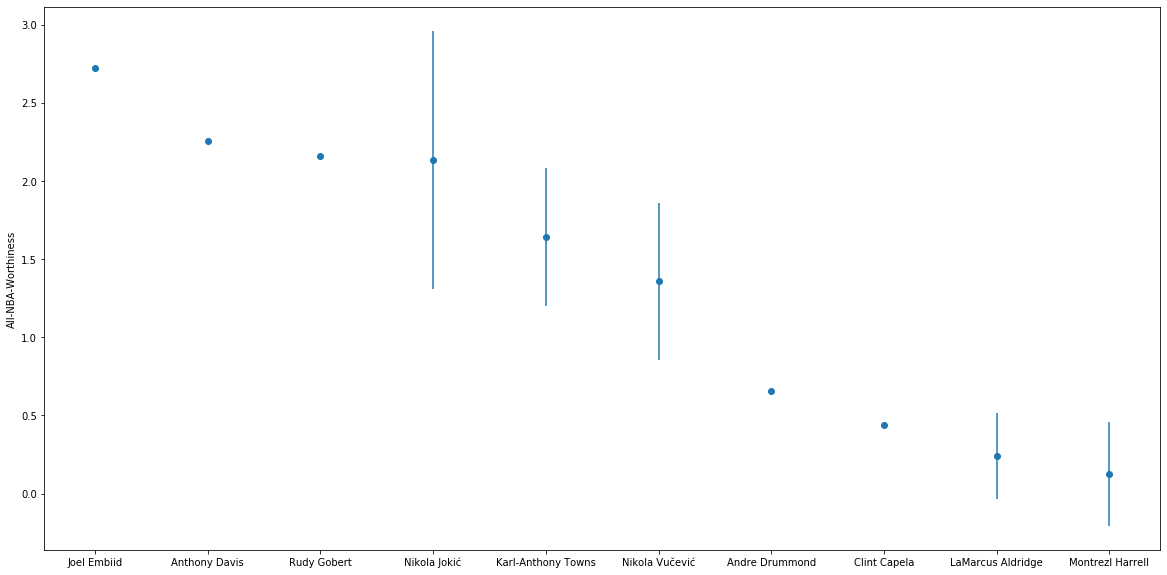

In [30]:
# Calculate the variance:
from sklearn.ensemble.forest import _generate_sample_indices
V_IJ_unbiased = random_forest_error(pipe, X_train, twenty_nineteen[features].astype(float))
import matplotlib.pyplot as plt

# Plot error bars for predicted votes using unbiased variance
plt.figure(figsize=(20,10))
plt.errorbar(twenty_nineteen['Player'], twenty_nineteen['votes'], yerr=np.sqrt(V_IJ_unbiased), fmt='o')
plt.ylabel('All-NBA-Worthiness')
plt.show()

No calibration with n_samples <= 20


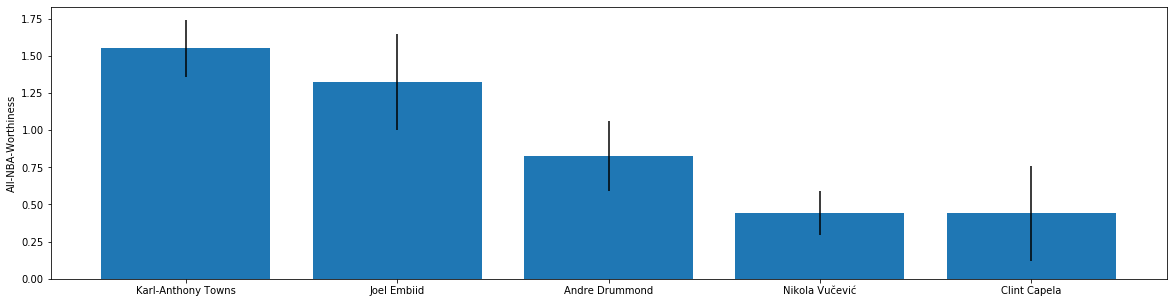

In [31]:
test_new = test.copy()
test_new['votes'] = pipe.predict(X_test)
predictions = test_new.sort_values(by='votes', ascending=False)[:5]# Calculate the variance:

V_IJ_unbiased = random_forest_error(pipe, X_train, predictions[features].astype(float))

# Plot error bars for predicted votes using unbiased variance
plt.figure(figsize=(20,5))
plt.bar(predictions['Player'], predictions['votes'], yerr=np.sqrt(V_IJ_unbiased))
plt.ylabel('All-NBA-Worthiness')
plt.show()

# Now to fit a Linear Regression model.

In [0]:
from sklearn.linear_model import LinearRegression
lin_mod = LinearRegression()
lin_mod.fit(X_train, y_train)
pred = lin_mod.predict(X_val)

In [33]:
lin_mod.score(X_train, y_train)

0.4926283977840038

### 2nd Model Eval Score

In [34]:
eval_score = lin_mod.score(X_val[validate['Season']=='2017-18'], y_val[validate['Season']=='2017-18'])
print("Eval score: {}".format(eval_score))

Eval score: -0.5567884406824886


In [35]:
test_score = lin_mod.score(X_val[validate['Season']=='2018-19'], y_val[validate['Season']=='2018-19'])
print("Test score: {}".format(test_score))

Test score: 0.1031553834972827


In [36]:
new_validate = validate.copy()
new_validate['votes'] = pred
new_validate = new_validate.sort_values(by='votes', ascending=False)[:20]
new_validate[new_validate['Season'] == '2017-18']

,key_0,GS,MP/G,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,votes,Season,team_city,Seed
38,291,81,30.4,6.2,11.2,.555,0.0,0.1,.143,6.2,11.2,.559,.556,4.1,7.2,.574,3.1,9.3,12.5,1.3,0.6,1.6,2.6,3.1,16.6,229,Dwight Howard,C,32,CHO,81,2463,20.5,.577,.008,.639,11.0,33.8,22.2,7.1,1.0,4.4,15.1,24.2,2.9,3.9,6.8,.132,-2.0,1.7,-0.3,1.1,1.206881,2017-18,Charlotte,10
24,174,78,33.7,6.0,11.3,.529,0.0,0.1,.000,6.0,11.2,.536,.529,3.1,5.1,.605,5.1,10.9,16.0,3.0,1.5,1.6,2.6,3.2,15.0,140,Andre Drummond,C,24,DET,78,2625,22.9,.555,.012,.448,16.4,36.4,26.2,14.3,2.2,4.3,15.9,21.2,4.6,5.7,10.3,.189,0.2,5.3,5.5,5.0,1.077585,2017-18,Detroit,9
25,184,63,30.3,8.1,16.8,.483,1.0,3.4,.308,7.0,13.4,.527,.514,5.7,7.4,.769,2.3,8.7,11.0,3.2,0.6,1.8,3.7,3.3,22.9,147,Joel Embiid,C,23,PHI,63,1912,22.9,.573,.203,.442,8.4,29.7,19.4,18.0,1.0,4.8,15.6,33.4,2.3,3.8,6.2,.155,0.1,2.5,2.6,2.2,0.959172,2017-18,Philadelphia,3
19,139,48,36.2,8.5,18.0,.470,2.2,6.1,.354,6.3,11.9,.530,.530,6.1,8.2,.746,2.2,10.7,12.9,5.4,1.6,1.6,5.0,3.8,25.2,112,DeMarcus Cousins,C,27,NOP,48,1737,22.6,.583,.340,.456,6.8,30.9,19.2,23.0,2.2,3.5,18.9,31.9,1.5,3.2,4.7,.130,1.9,3.6,5.5,3.3,0.801731,2017-18,New Orleans,6
30,222,56,32.4,4.9,7.9,.622,0.0,0.0,0,4.9,7.9,.622,.622,3.6,5.3,.682,2.9,7.8,10.7,1.4,0.8,2.3,1.9,2.7,13.5,178,Rudy Gobert,C,25,UTA,56,1816,20.7,.657,.000,.673,10.4,27.0,18.8,6.9,1.2,6.0,15.7,16.9,4.2,3.9,8.1,.214,-0.3,4.6,4.3,2.9,0.760242,2017-18,Utah,5
14,107,74,27.5,6.0,9.1,.652,0.0,0.0,.000,6.0,9.1,.653,.652,1.9,3.5,.560,3.3,7.6,10.8,0.9,0.8,1.9,1.4,2.5,13.9,85,Clint Capela,C,23,HOU,74,2034,24.5,.650,.001,.380,13.5,30.8,22.2,5.7,1.4,5.7,11.5,19.4,6.2,4.1,10.2,.242,0.1,2.9,3.0,2.6,0.743740,2017-18,Houston,1
3,6,75,33.5,9.2,18.0,.510,0.4,1.2,.293,8.8,16.7,.526,.520,4.5,5.3,.837,3.3,5.2,8.5,2.0,0.6,1.2,1.5,2.1,23.1,7,LaMarcus Aldridge,C,32,SAS,75,2509,25.0,.570,.068,.296,10.8,17.3,14.0,11.3,0.9,3.0,6.8,29.1,7.4,3.5,10.9,.209,3.0,0.3,3.3,3.3,0.714163,2017-18,San Antonio,7
84,615,82,35.6,7.8,14.3,.545,1.5,3.5,.421,6.3,10.8,.585,.596,4.2,4.9,.858,2.9,9.4,12.3,2.4,0.8,1.4,1.9,3.5,21.3,483,Karl-Anthony Towns,C,22,MIN,82,2918,24.9,.646,.243,.343,9.3,30.9,20.0,10.8,1.1,3.5,10.5,22.9,10.6,3.4,14.0,.230,4.4,1.1,5.5,5.5,0.670263,2017-18,Minnesota,8


In [37]:
new_validate[new_validate['Season'] == '2018-19']

,key_0,GS,MP/G,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,votes,Season,team_city,Seed
31,253,80,31.8,5.9,8.8,.669,0.0,0.0,0,5.9,8.8,.669,.669,4.1,6.4,.636,3.8,9.0,12.9,2.0,0.8,2.3,1.6,2.9,15.9,187,Rudy Gobert,C,26,UTA,81,2577,24.6,.682,.000,.733,13.2,30.2,21.9,9.6,1.2,5.8,12.1,17.8,8.7,5.7,14.4,.268,2.0,5.1,7.0,5.9,1.677461,2018-19,Utah,5
27,207,64,33.7,9.1,18.7,.484,1.2,4.1,.300,7.8,14.6,.535,.517,8.2,10.1,.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,155,Joel Embiid,C,24,PHI,64,2154,26.1,.593,.219,.541,8.1,34.0,21.4,18.4,1.0,4.4,13.2,33.3,4.9,3.8,8.7,.194,2.0,2.1,4.1,3.3,1.435866,2018-19,Philadelphia,3
19,167,56,33.0,9.5,18.3,.517,0.9,2.6,.331,8.6,15.7,.547,.540,6.1,7.7,.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,126,Anthony Davis,C,25,NOP,56,1850,30.3,.597,.141,.422,9.9,27.5,18.8,19.0,2.2,6.0,8.4,29.5,6.4,3.1,9.5,.247,4.7,3.9,8.5,4.9,1.305544,2018-19,New Orleans,13
33,279,5,26.3,6.7,10.8,.615,0.0,0.2,.176,6.6,10.6,.623,.617,3.2,5.0,.643,2.2,4.3,6.5,2.0,0.9,1.3,1.6,3.1,16.6,208,Montrezl Harrell,C,25,LAC,82,2158,23.4,.636,.019,.466,9.3,16.7,13.1,12.5,1.6,4.0,11.0,23.5,6.1,2.6,8.7,.193,2.6,1.6,4.2,3.4,1.125118,2018-19,Los Angeles Clippers,8
26,195,79,33.5,7.1,13.3,.533,0.1,0.5,.132,7.0,12.8,.548,.536,3.1,5.2,.590,5.4,10.2,15.6,1.4,1.7,1.7,2.2,3.4,17.3,147,Andre Drummond,C,25,DET,79,2647,23.4,.555,.036,.392,16.8,34.7,25.4,7.2,2.5,4.4,12.4,22.9,4.1,5.9,10.0,.181,-0.7,3.6,2.9,3.3,0.987238,2018-19,Detroit,8
44,366,80,31.3,7.7,15.1,.511,1.0,3.4,.307,6.7,11.7,.569,.545,3.6,4.4,.821,2.9,8.0,10.8,7.3,1.4,0.7,3.1,2.9,20.1,269,Nikola Jokić,C,23,DEN,80,2504,26.3,.589,.224,.292,9.8,27.6,18.7,37.0,2.1,1.9,15.4,27.4,7.5,4.3,11.8,.226,5.7,3.8,9.5,7.3,0.880703,2018-19,Denver,2
73,670,77,33.1,8.8,17.1,.518,1.8,4.6,.400,7.0,12.5,.562,.572,4.9,5.8,.836,3.4,9.0,12.4,3.4,0.9,1.6,3.1,3.8,24.4,480,Karl-Anthony Towns,C,23,MIN,77,2545,26.3,.622,.270,.342,10.9,29.3,20.0,17.2,1.3,4.2,13.7,28.9,7.2,3.2,10.4,.197,4.8,2.0,6.8,5.7,0.806148,2018-19,Minnesota,11
76,685,80,31.4,8.8,16.9,.518,1.1,2.9,.364,7.7,14.0,.549,.549,2.2,2.8,.789,2.8,9.2,12.0,3.8,1.0,1.1,2.0,2.0,20.8,492,Nikola Vučević,C,28,ORL,80,2510,25.5,.573,.171,.168,9.4,31.9,20.5,21.9,1.6,3.0,9.9,28.0,5.4,4.7,10.1,.193,3.0,3.4,6.4,5.3,0.730563,2018-19,Orlando,7
60,528,72,27.4,5.8,11.5,.508,0.0,0.4,.103,5.8,11.1,.523,.510,3.9,5.1,.773,3.4,7.0,10.4,3.2,1.0,1.4,2.3,3.5,15.6,381,Jusuf Nurkić,C,24,POR,72,1974,23.4,.570,.035,.442,13.4,26.7,20.2,17.9,1.7,4.2,14.6,24.7,4.4,3.3,7.8,.189,1.6,3.6,5.1,3.5,0.716360,2018-19,Portland,3
79,703,53,23.3,5.4,9.4,.571,0.0,0.2,.125,5.4,9.2,.581,.572,1.5,3.4,.449,3.6,7.8,11.3,0.8,0.6,1.9,1.3,2.7,12.3,509,Hassan Whiteside,C,29,MIA,72,1674,23.5,.564,.024,.357,16.3,35.6,25.9,5.6,1.3,7.3,11.0,22.6,2.3,4.0,6.3,.180,-2.2,3.0,0.8,1.2,0.692896,2018-19,Miami,10


In [0]:
columns = X_train.columns
coef = pd.Series(lin_mod.coef_, columns)

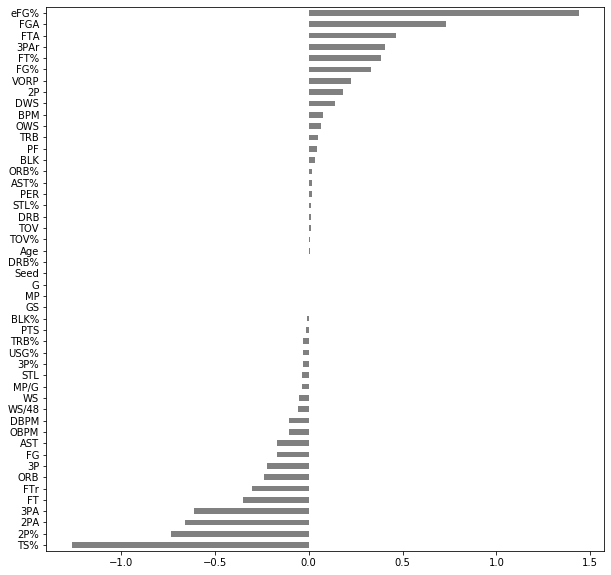

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
coef.sort_values().plot.barh(color='grey')

# Permutation Importance Section

In [40]:
!pip install eli5

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

# 1. Calculate permutation importances
permuter = PermutationImportance(
    pipe, 
    scoring='r2', 
    n_iter=5,
)

permuter.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [42]:
permuter.score(X_val, y_val)

0.24428517890354184

In [43]:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.2375 ± 0.0130,WS
0.2374 ± 0.0214,FTA
0.1348 ± 0.0154,DWS
0.0859 ± 0.0036,PTS
0.0353 ± 0.0019,2P
0.0236 ± 0.0015,VORP
0.0214 ± 0.0026,DRB
0.0213 ± 0.0041,PF
0.0183 ± 0.0005,PER
0.0169 ± 0.0020,Age


In [0]:
importances = pipe.feature_importances_

In [0]:
columns = X_val.columns
importances = pd.Series(importances, columns)

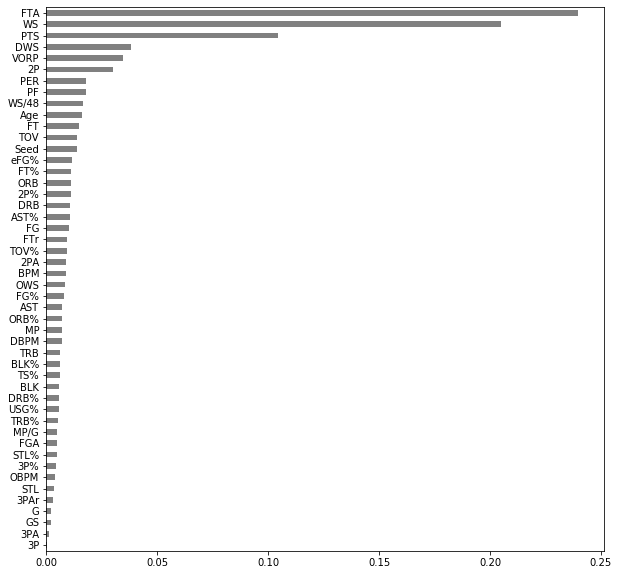

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh(color='grey')

# Partial Dependence Plot

In [47]:
!pip install pdpbox

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
features = ['PTS', 'AST']
condition = (X_train['PTS'] > 12) & (X_train['AST'] > 3)
interaction = pdp_interact(
    model=pipe, 
    dataset=X_train[condition],
    model_features=X_train[condition].columns, 
    features=features,
    num_grid_points=[20,20]
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


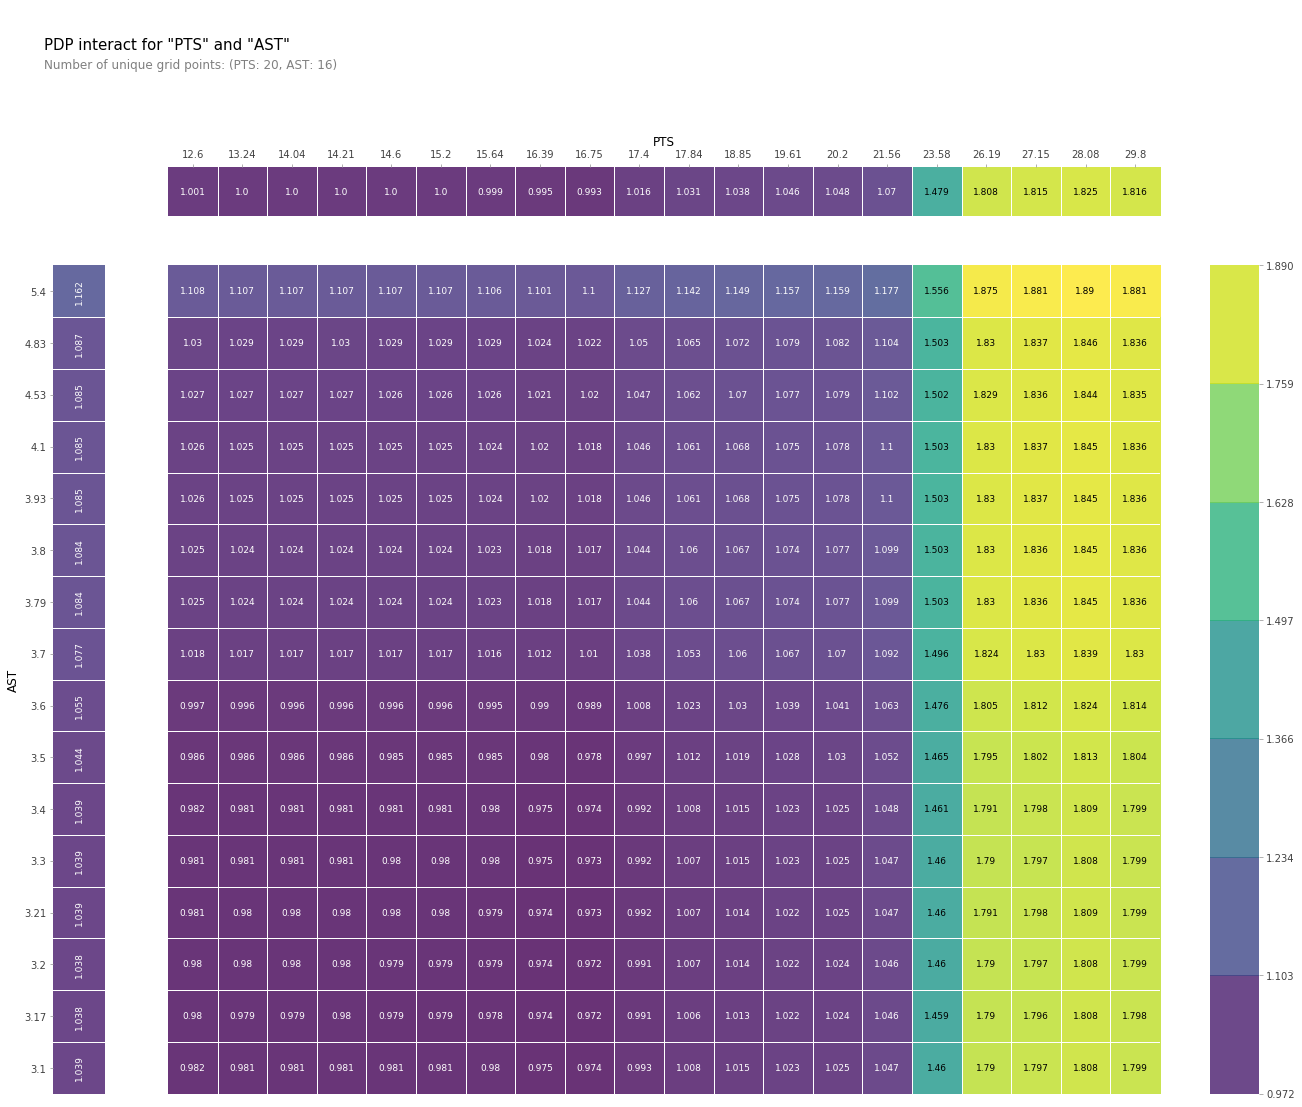

In [50]:
pdp_interact_plot(interaction, plot_type='grid', figsize=(20,20), plot_pdp=True,
                  feature_names=features);

In [0]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

In [52]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()